# Lab 6 Report: 
## Audio Filtering with Gated RNNs

### Name:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import IPython

from scipy.io.wavfile import write

In [2]:
from IPython.display import Image # For displaying images in colab jupyter cell

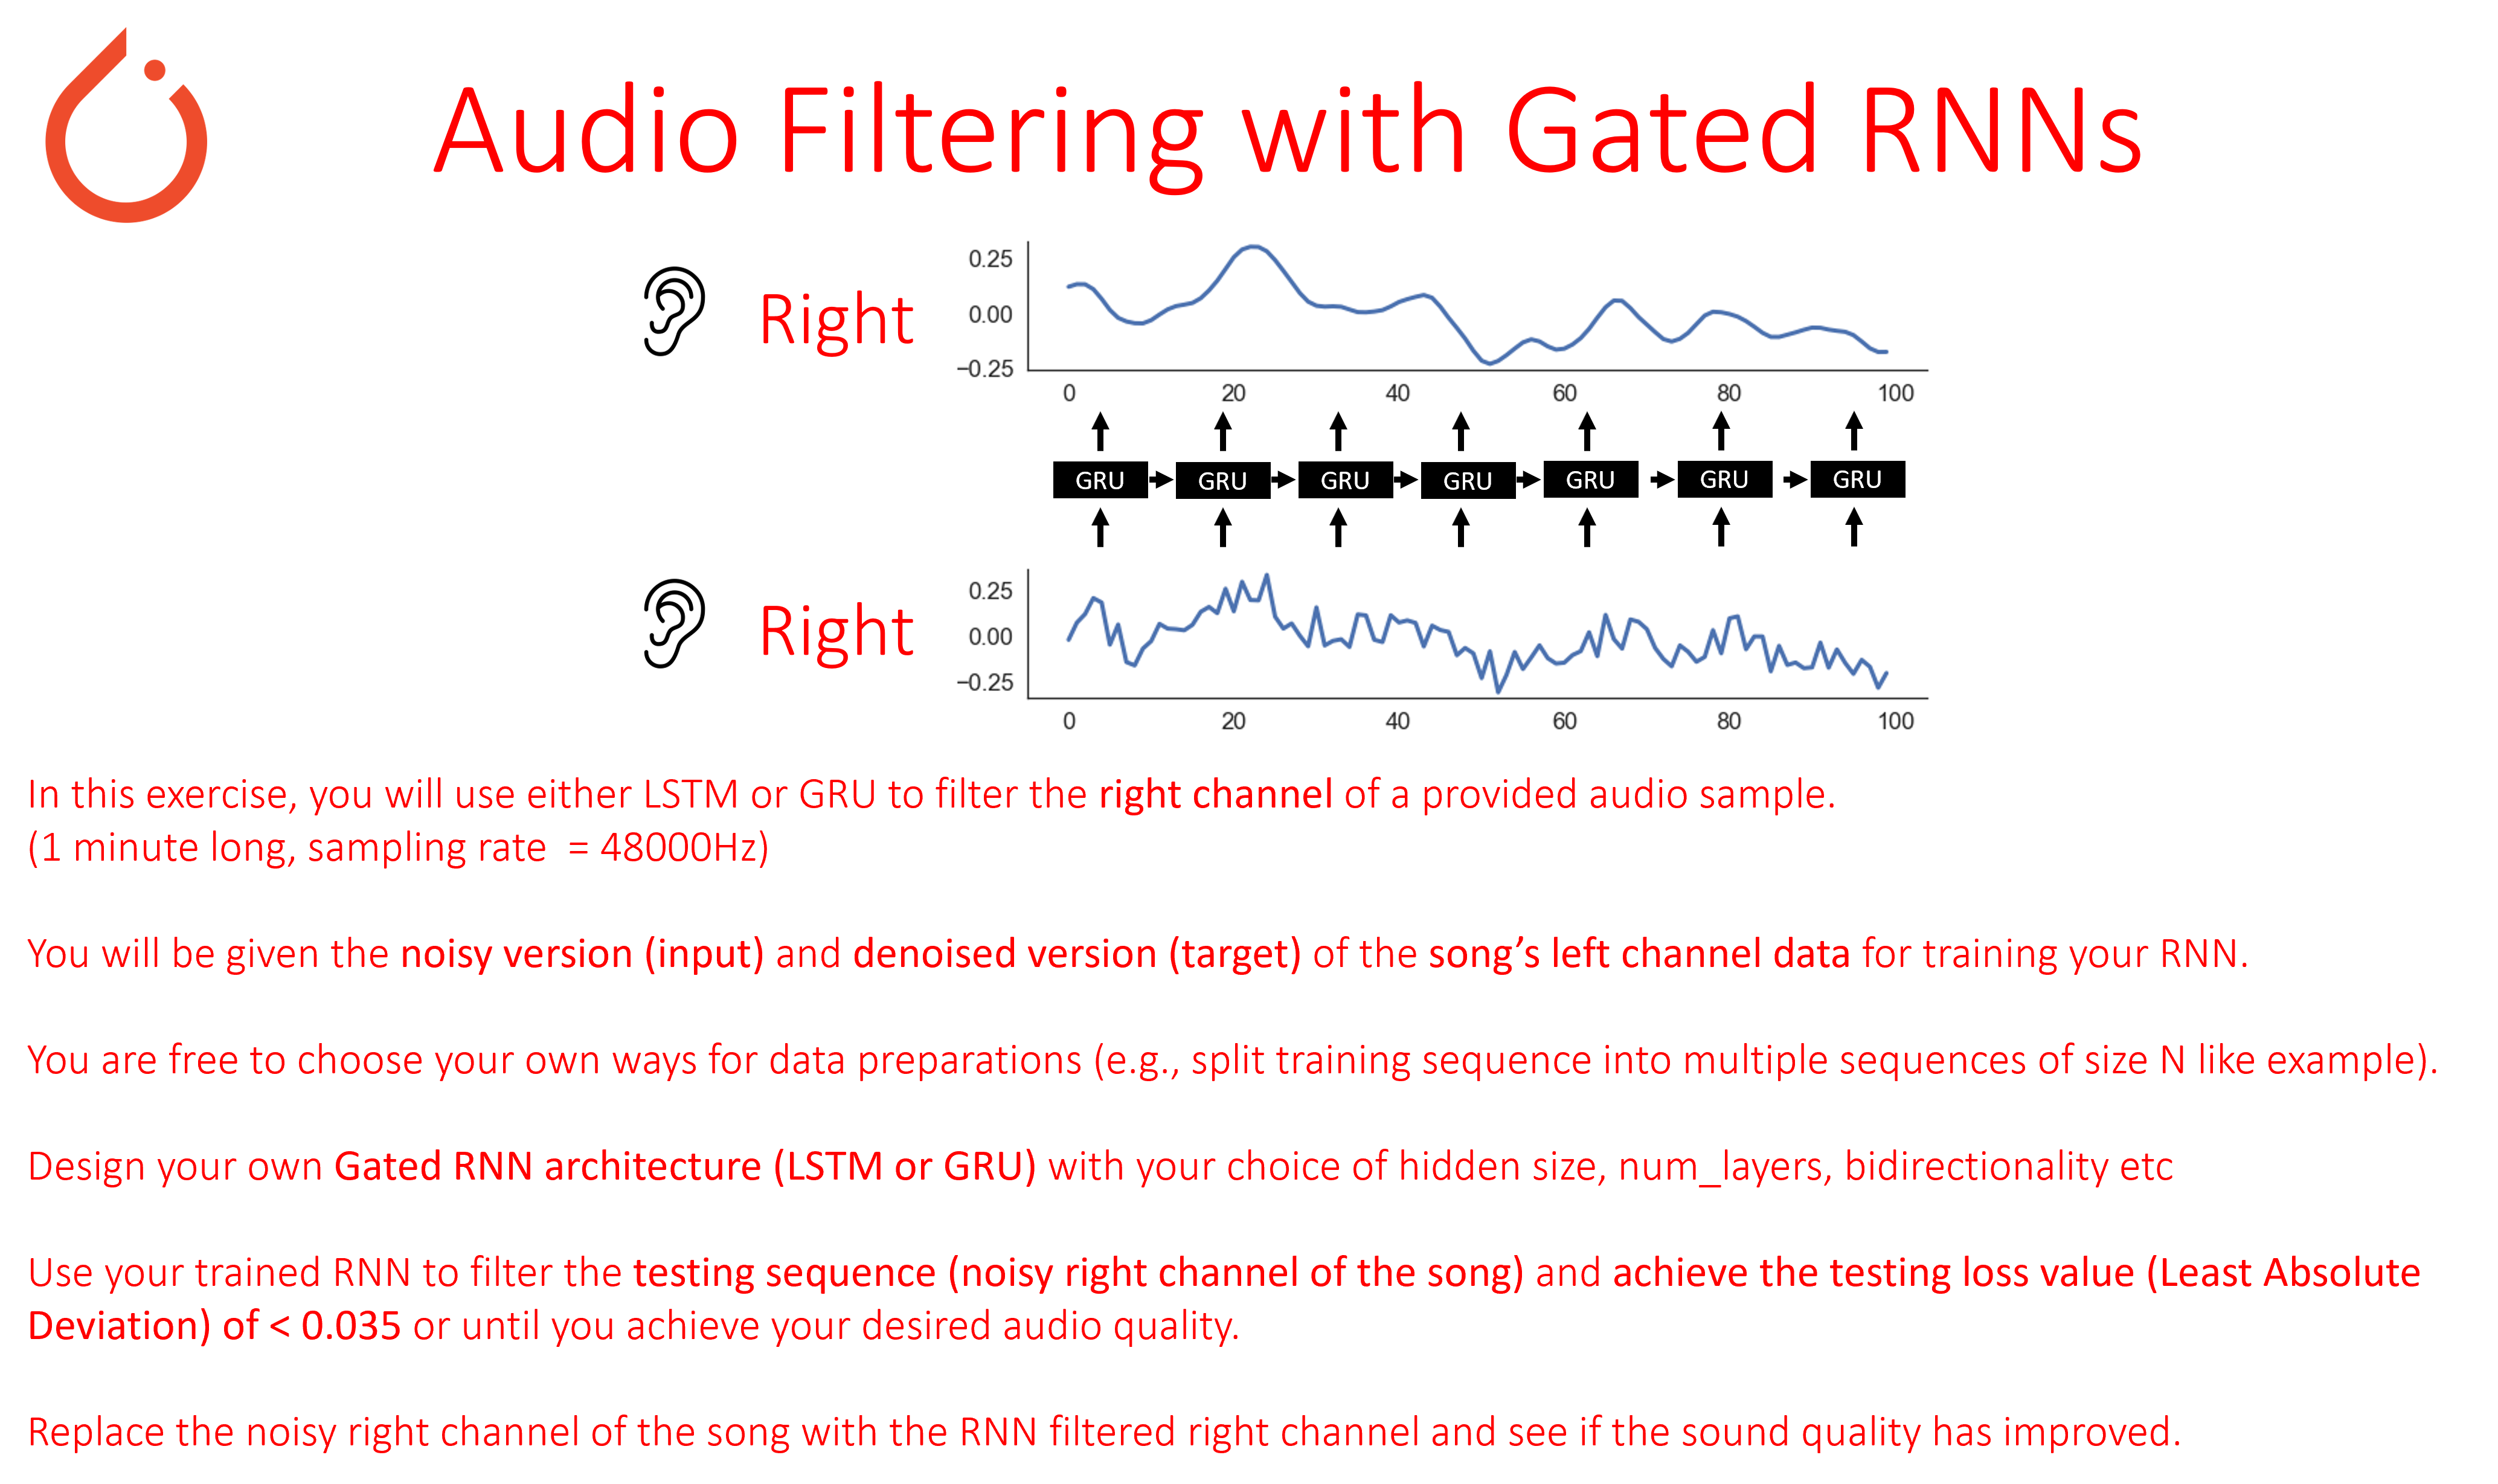

In [3]:
Image('lab6_exercise.png', width = 1000)

In [4]:
sns.set(style = 'white', font_scale = 1.5)

## Prepare Data

In [28]:
# Listen to audio with noisy right channel
# Our goal is to use RNN to denoise the right channel
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS

import IPython
'''
IPython.display.Audio("TSR_noisy.wav")
'''

'\nIPython.display.Audio("TSR_noisy.wav")\n'

In [6]:
train_input_seqs = np.load('audio_train_inputs.npy') # Noisy left channel audio (training inputs to your RNN)
train_output_seqs = np.load('audio_train_targets.npy') # Ground truth left channel audio (trining targets for your RNN)

# Print the length of training features and targets
print(len(train_input_seqs), len(train_output_seqs))

2754000 2754000


In [7]:
# Reshape train_input_seqs and train_output_seqs to 2D arrays
# Each row corresponds to a single training input/target sequence
# e.g., if your training sequence length = 100 -> train_input_seqs/output_seqs should have shape (27540, 100)
# Feel free to choose your own training sequence length

train_input_seqs = train_input_seqs.reshape(27540, 100)
train_output_seqs = train_output_seqs.reshape(27540, 100)

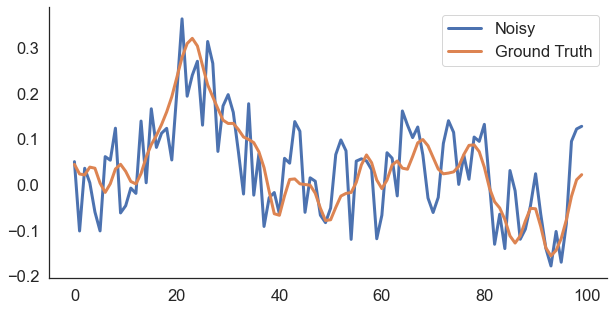

In [8]:
# let's plot one of the training input sequence/output target (10th sample)
# Feel free to plot a different sample

plt.figure(figsize = (10, 5))

plt.plot(train_input_seqs[105], label ='Noisy', linewidth = 3)
plt.plot(train_output_seqs[105], label ='Ground Truth', linewidth = 3)
plt.legend()
sns.despine()

In [9]:
# Reshape train_input_seqs and output_seqs again to conform to PyTorch (sample size (N), sequence length, # of features)

train_input_seqs = train_input_seqs.reshape((train_input_seqs.shape[0], -1, 1))
train_output_seqs = train_output_seqs.reshape((train_output_seqs.shape[0], -1, 1))

print(train_input_seqs.shape)


print(train_output_seqs.shape)

(27540, 100, 1)
(27540, 100, 1)


## Define Model

In [10]:
class Denoiser_LSTM(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        
        super(Denoiser_LSTM, self).__init__()
        
        # using LSTM cell with batch_first = True, thus using (sample_size, sequence_length, # of features) format
        # bidirectional = False, so only forward context is taken
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                                  num_layers=num_layers,
                                  batch_first=True,
                                  bidirectional=False)
        
        # decoder layer to take in LSTM hidden states and output a single number (denoised value at time t)
        self.decoder = torch.nn.Linear(hidden_size, output_size)
        
        # uses Tanh activation to squeeze the decoder output between -1 and 1
        # (data consists of sinusodial between -1 and 1)
        self.output_activation = torch.nn.Tanh()
        
    def forward(self, input_seq, hidden_state):
        
        # feed the LSTM cell with input sequence and initial hidden state
        pred, hidden = self.lstm(input_seq, hidden_state)
        
        # feed the output of LSTM (pred) to decoder layer, followed by taking the Tanh activation
        denoised_seq = self.output_activation(self.decoder(pred))
        
        return denoised_seq

## Define Hyperparameters

In [11]:
# Define your model
denoiser_LSTM = Denoiser_LSTM(input_size=1, hidden_size=30, 
                            num_layers=1, output_size=1)

# Define lr and epochs
learning_rate = 0.0003  
epochs = 30

# Define mini-batch size
batchsize = 100

# Use L1Loss to minimize least absolute deviation + optimizer
loss_func = torch.nn.L1Loss()
optimizer = torch.optim.Adam(denoiser_LSTM.parameters(), lr=learning_rate)

# Print out model specifics, add .cuda() if using GPU
denoiser_LSTM

Denoiser_LSTM(
  (lstm): LSTM(1, 30, batch_first=True)
  (decoder): Linear(in_features=30, out_features=1, bias=True)
  (output_activation): Tanh()
)

## Identify Tracked Values

In [12]:
# Empty list to keep track of training loss

train_loss_list = []

## Train Model

In [13]:
# Convert your training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split your training data into mini-batches
train_batches_features = torch.split(train_input_seqs, batchsize)
train_batches_targets = torch.split(train_output_seqs, batchsize)

# total number of mini-batches in the training set
batch_split_num = len(train_batches_features)

for epoch in range(epochs):
    
    for k in range(batch_split_num): # mini-batch 
        
        # initialize the hidden states as None
        hidden_state = None
        
        # feed in the k-th mini-batch training features to LSTM + hidden states to produce output 
        pred = denoiser_LSTM(train_batches_features[k], hidden_state)
        
        # zero_grad() to clear gradient buffer
        optimizer.zero_grad()
        
        # compute loss between the LSTM denoised sequence vs target training sequence
        loss = loss_func(pred, train_batches_targets[k])
        # append loss
        train_loss_list.append(loss.item())
        
        # backpropagation
        loss.backward()
        
        # update weights/biases
        optimizer.step()

    print("Averaged Training Loss for Epoch ", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch  0 :  0.13076723519496727
Averaged Training Loss for Epoch  1 :  0.05994113145963005
Averaged Training Loss for Epoch  2 :  0.05378082867009916
Averaged Training Loss for Epoch  3 :  0.051231787189085415
Averaged Training Loss for Epoch  4 :  0.049911158442821194
Averaged Training Loss for Epoch  5 :  0.049085529588594815
Averaged Training Loss for Epoch  6 :  0.04848181314604438
Averaged Training Loss for Epoch  7 :  0.04799977796611147
Averaged Training Loss for Epoch  8 :  0.04760749272300281
Averaged Training Loss for Epoch  9 :  0.047286358257026775
Averaged Training Loss for Epoch  10 :  0.047014703555707485
Averaged Training Loss for Epoch  11 :  0.04677904848063338
Averaged Training Loss for Epoch  12 :  0.046566916710656624
Averaged Training Loss for Epoch  13 :  0.04637441032336674
Averaged Training Loss for Epoch  14 :  0.046195533221074635
Averaged Training Loss for Epoch  15 :  0.046031609272071415
Averaged Training Loss for Epoch  16 :  0.

## Visualize & Evaluate Model

### Visualizing Training Loss

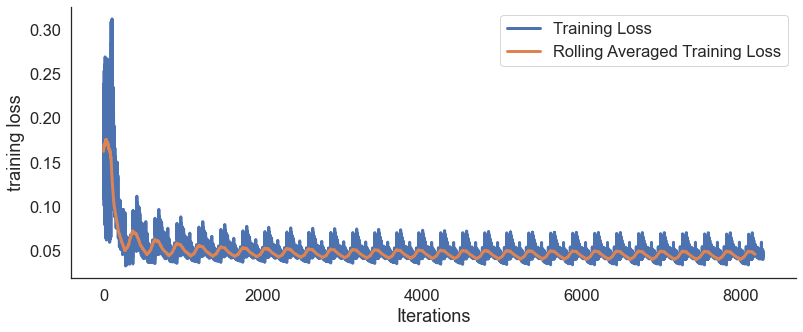

In [14]:
# Plot your training loss throughout the training 

plt.figure(figsize = (13, 5))

plt.plot(train_loss_list, linewidth = 3, label = 'Training Loss')
plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')

plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

### Computing Testing Loss

In [15]:
# Load test features (Noisy right channel) and test targets for computing the test loss

test_input_seqs = np.load('audio_test_inputs.npy') # Noisy right channel audio (to be used as inputs to your trained RNN)
test_output_seqs = np.load('audio_test_targets.npy') # Groundtruth right channel audio (to compute the test loss)

In [16]:
# Test features/targets have same dimension as training feature/targets

print(len(test_input_seqs), len(test_output_seqs))

2754000 2754000


In [17]:
# Convert your test_input_seqs and output_seqs into torch tensors
test_input_seqs = torch.from_numpy(test_input_seqs).float()
test_output_seqs = torch.from_numpy(test_output_seqs).float()

# Reshape your test_input_seqs and output_seqs to 2D arrays as you did with train_input_seqs and output_seqs
test_input_seqs = test_input_seqs.reshape(27540, 100)
test_output_seqs = test_output_seqs.reshape(27540, 100)


# Reshape the test_input_seqs and output_seqs again to conform to (sample size (N), sequence length, # of features)
test_input_seqs = test_input_seqs.reshape((test_input_seqs.shape[0], -1, 1))
test_output_seqs = test_output_seqs.reshape((test_output_seqs.shape[0], -1 ,1))

In [18]:
# Each noisy test input sequence is fed into your trained RNN to produce denoised outputs
# We need to take mini-batch approach since our test_features is too big to feed it all in once (i.e. not enough memory)

# Split the test_features and targets to mini-batches
test_batches_features = torch.split(test_input_seqs, batchsize)
test_batches_targets = torch.split(test_output_seqs, batchsize)

batch_split_num_test = len(test_batches_features)

# Empty lists to keep track of RNN denoised test sequences and test losses
test_prediction = []
test_losses = []

# Turn on no_grad() since we aren't performing backprop during this process
with torch.no_grad():
    
    for k in range(batch_split_num_test):
        
        # Feed in k-th test mini-batch to trained RNN
        test_pred = denoiser_LSTM(test_batches_features[k], None)
        # Compre the test_pred with test target sequence to compute testing loss
        test_loss = loss_func(test_pred, test_batches_targets[k])
        
        # Use torch.squeeze() to make test_pred to shape (batchsize, seq_len) and convert it to numpy array
        test_pred_numpy = torch.squeeze(test_pred).numpy()
        
        # Append both test_pred_numpy and test_loss 
        test_prediction.append(test_pred_numpy)
        test_losses.append(test_loss.item())
        
# Final testing loss is the average of all the test_losses from mini-batches        
print("Testing Loss (Least Absolute Deviations): ", np.mean(test_losses))

Testing Loss (Least Absolute Deviations):  0.04706214547859154


### Creating a new audio with denoised right channel sequence

In [19]:
# test_prediction is a list of 2D arrays where each array has shape (batchsize, seq_len)
# Vertically stack all appended 2D arrays so that we have a single 2D array
test_prediction = np.vstack(test_prediction)

print(test_prediction.shape)

(27540, 100)


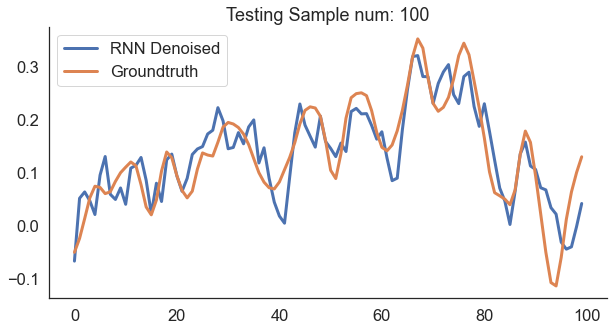

In [20]:
# We can visualize RNN denoised test sequence vs ground truth test sequence for particular sample
test_sample_num = 100
    
plt.figure(figsize = (10, 5))

# plt.plot(test_input_seqs[test_sample_num], label='RNN not Denoised', linewidth = 3)
plt.plot(test_prediction[test_sample_num], label='RNN Denoised', linewidth = 3)
plt.plot(test_output_seqs[test_sample_num], label='Groundtruth', linewidth = 3)
plt.legend()
plt.title("Testing Sample num: {}".format(test_sample_num))
sns.despine()

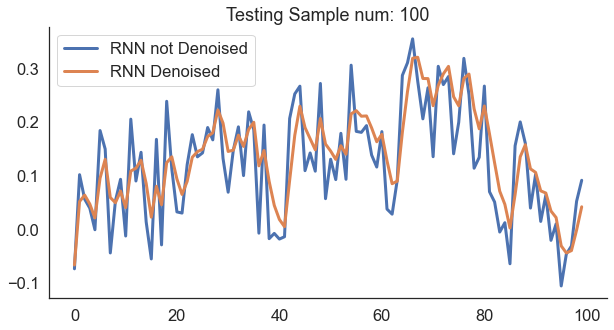

In [21]:
test_sample_num = 100
    
plt.figure(figsize = (10, 5))

plt.plot(test_input_seqs[test_sample_num], label='RNN not Denoised', linewidth = 3)
plt.plot(test_prediction[test_sample_num], label='RNN Denoised', linewidth = 3)
#plt.plot(test_output_seqs[test_sample_num], label='Groundtruth', linewidth = 3)
plt.legend()
plt.title("Testing Sample num: {}".format(test_sample_num))
sns.despine()

In [22]:
# Reshape the test_prediction to 1D array of size 2754000 so that we can use it as the right channel of the song
test_prediction = test_prediction.reshape(2754000)

# Reshape the train_output_seqs (ground truth left channel of the song) to 1D array as well
train_output_seqs = train_output_seqs.reshape(2754000)

# convert the tensor train_output_seqs to numpy array in order to use hstack
train_output_seqs = train_output_seqs.numpy()

# Construct an array 'fixed_audio' of size (2754000, 2) 
# where the first column (left channel) is 1D reshaped train_output_seqs (groundtruth left channel)
# And second column (right channel) is the 1D reshaped test_prediction (RNN denoised)

fixed_audio = np.hstack((test_prediction, train_output_seqs))

In [23]:
# Scale the fixed_audio so that it's in int16 form and write it into a new audio file

scaled = np.int16(fixed_audio/np.max(np.abs(fixed_audio)) * 32767)
write('TSR_fixed.wav', 48000, scaled)

In [26]:
# Listen to the new audio with denoised right channel
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS
'''
IPython.display.Audio("TSR_fixed.wav")
'''

'\nIPython.display.Audio("TSR_fixed.wav")\n'

In [27]:
# Compare your denoised audio with ground truth audio for reference
# USE HEADPHONES OR SET YOUR LAPTOP VOLUME TO LOW IF YOU ARE LISTENING IN THE CLASS

'''
IPython.display.Audio("TSR.wav")
'''

'\nIPython.display.Audio("TSR.wav")\n'